In [1]:
# imports 
import numpy as np 
import matplotlib.pyplot as plt 
from dataloader import * 
from testCases import * 
import h5py

%matplotlib inline 
plt.rcParams["figure.figsize"] = (7.0, 4.0) 
plt.rcParams["image.interpolation"] = 'nearest'
plt.rcParams["image.cmap"] = 'gray'

# All needed functions 

In [2]:
# sigmoid 
def sigmoid(x):
    s = 1/(1 + np.exp(-x))
    return s 

# ReLu
def relu(x): 
    s = np.maximum(0, x)
    return s


In [3]:
# initialize parameters 
def initialize_parameters(layer_dims):
    # to keep the output same 
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters["W" + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layer_dims[l],1))
        
    return parameters

In [4]:
## forward propagation 
def forward_propagation(X, parameters):
    
    # retrieve parameters 
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # forward calculation 
    Z1 = np.dot(W1,X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3 
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2 ,Z3, A3, W3, b3)
    
    return A3, cache
    

In [5]:
# Backward propagation 
def backward_propagation(X, Y, cache):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2 ,Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1./m)*np.dot(dZ3, A2.T)
    db3 = (1./m)*np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1./m)*np.dot(dZ2,A1.T)
    db2 = (1./m)*np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1>0))
    dW1 = (1./m)*np.dot(dZ1, X.T)
    db1 = (1./m)*np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [6]:
# update parameters 
def update_parameters(parameters, grads, learning_rate):
    
    # L number of layers of neural network 
    L = len(parameters)//2
    
    # update rule 
    for l in range(L): 
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l + 1)]
        
    return parameters



In [7]:
# prediction 
def predict(X, y, parameters):
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # forward propagation 
    a3, caches = forward_propagation(X, parameters)
    
    # convert probabilities to 0/1 predictions
    p[a3 > 0.5] = 1
    
    # accuracy 
    print("Accuracy:" + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [8]:
# compute cost 
def compute_cost(a3,Y):
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3), Y) + np.multiply(-np.log(1 - a3), (1-Y))
    cost = (1./m)*np.nansum(logprobs)
    
    return cost 

In [9]:
# loading dataset 
def load_dataset(): 
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])
    
    test_dateset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dateset["test_set_x"][:])
    test_set_y_orig = np.array(test_dateset["test_set_y"][:])
    
    classes = np.array(test_dateset["list_classes"][:])
    
    train_set_y = train_set_y_orig.reshape((1,train_set_y_orig.shape[0]))
    test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
    
    train_set_x = train_set_x_orig/ 255
    test_set_x = test_set_x_orig/255
    
    return train_set_x, train_set_y, test_set_x, test_set_y, classes

In [10]:
# predict_dec 
def predict_dec(parameters, X):
    
    a3, cache = forward_propagation(X, parameters)
    prediction = (a3 > 0.5)
    return prediction

## cost and back prop with regularization

In [11]:
# compute cost with regularization 
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y)
    
    # L2 regularization term 
    regularization_cost = (1./m)*(lambd/2)*(np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    
    # Total cost 
    total_cost = cross_entropy_cost + regularization_cost
    
    return total_cost

# backward_propagation_with_regularization 
def backward_propagation_with_regularization(X, Y, cache, lambd):
    
    """
    With regularization, each calculation of dw will have and added term of regularization
    with it 
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1./m)*np.dot(dZ3, A2.T) + (lambd/m)*W3
    db3 = (1./m)*np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3) 
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1./m)*np.dot(dZ2, A1.T) + (lambd/m)*W2
    db2 = (1./m)*np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1,np.int64(A1 > 0))
    dW1 = (1./m)*np.dot(dZ1, X.T) + (lambd/m)*W1
    db1 = (1./m)*np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients
    
    

## forward and backward propagation with dropout 

In [12]:
# forward propagation with dropout 
def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):
    
    # fixing randomenss for similar result 
    np.random.seed(1)
    
    # retrive parameters 
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # forward propagation 
    Z1 = np.dot(W1, X) + b1 
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = (D1 < keep_prob).astype(int)
    A1 = A1*D1 # set some values to zero
    A1 = A1/keep_prob # scale to maintain the effect 
    
    Z2 = np.dot(W2, A1) + b2 
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = (D2 < keep_prob).astype(int)
    A2 = A2*D2
    A2 = A2/keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

# backwars propagation with dropout
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1./m)*np.dot(dZ3, A2.T)
    db3 = (1./m)*np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2*D2
    dA2 = dA2/keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1./m)*np.dot(dZ2, A1.T)
    db2 = (1./m)*np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1*D1
    dA1 = dA1/keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = (1./m)*np.dot(dZ1, X.T)
    db1 = (1./m)*np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients
    
    

# implementing different models 

* we will implement three different models 
    - non regularized model 
    - L2 regularized model 
    - Drop out regularized model 

## Non-regularized model

* value of regularization is 0
* value of dropout value, keep probs, is set to 1

In [13]:
# non-regularized model 
def model(X, Y, learning_rate=0.3, num_iteration=30000, print_cost=True, lambd=0, keep_prob=1):
    """
    This implementation works without regularization, to implement this we will keep the value of regularization 
    parameter lambda to be zero and fix the drop out probability to be 1, which means no dropout.
    """
    
    grads = {}
    costs = []
    m = X.shape[1]
    layer_dims = [X.shape[0], 20, 10, 1]
    
    # initialize parameters dictionary by calling the function initialize_parameters()
    parameters = initialize_parameters(layer_dims)
    
    # Loopg for gradient descent
    
    for i in range(0, num_iteration):
        
        # Forwars propagation 
        # this also controls the dropout regularization 
        if keep_prob == 1: 
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1: 
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
            
        # compute cost 
        if lambd ==0: 
            cost = compute_cost(a3, Y)
        else: 
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
        
        # Backward propagation 
        assert(lambd == 0 or keep_prob ==1)
        
        if lambd ==0 and keep_prob ==1: 
            grads = backward_propagation(X, Y, cache)
        elif lambd !=0: 
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1: 
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters. 
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # print costs 
        if print_cost and i % 10000 ==0: 
            print(f"Cost after iteration {i}: {cost}")
        if print_cost and i % 1000 == 0: 
            costs.append(cost)
            
    # plot the cost 
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters
    

## Loading dataset 

In [14]:
# loading 2D dataset 
# train_X, train_Y, test_X, test_Y = load_2D_dataset()

# loading planar dataset 
train_X, train_Y = load_planar_dataset(1)


Cost after iteration 0: 1.4572499628902362


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Cost after iteration 10000: 0.1416789062674393
Cost after iteration 20000: 0.13416644729263577


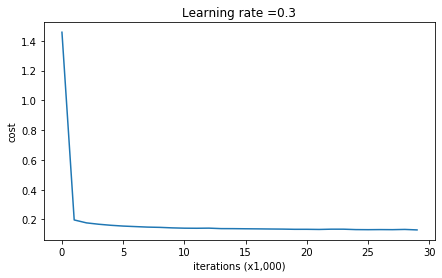

On the training set:
Accuracy:0.945
On the test set:


In [15]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
# predictions_test = predict(test_X, test_Y, parameters)

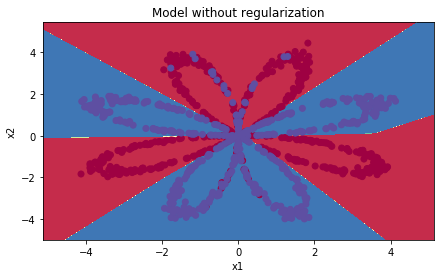

In [16]:
plt.title("Model without regularization")
axes = plt.gca()
# axes.set_xlim([-0.75,0.40])
# axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

# with regularization 

Cost after iteration 0: 1.4652542455139026


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Cost after iteration 10000: 0.20818960734147451
Cost after iteration 20000: 0.2052810695218562


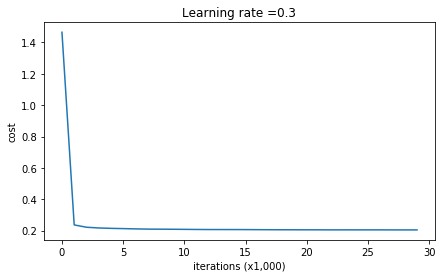

On the train set:
Accuracy:0.935
On the test set:


In [17]:
parameters = model(train_X, train_Y, lambd = 0.5)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
# predictions_test = predict(test_X, test_Y, parameters)

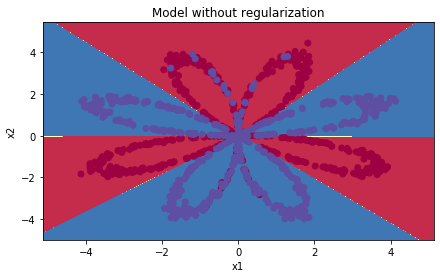

In [18]:
plt.title("Model without regularization")
axes = plt.gca()
# axes.set_xlim([-0.75,0.40])
# axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

# With dropout 

Cost after iteration 0: 1.5002619841199425


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Cost after iteration 10000: 0.12998586018613933
Cost after iteration 20000: 0.10491668443415078


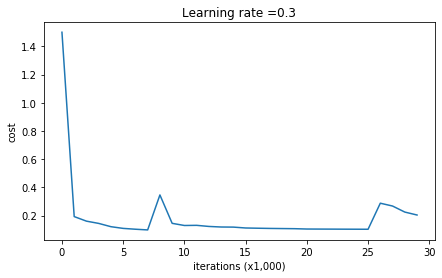

On the train set:
Accuracy:0.907
On the test set:


In [19]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
# predictions_test = predict(test_X, test_Y, parameters)

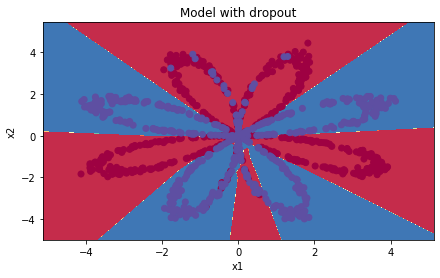

In [20]:
plt.title("Model with dropout")
axes = plt.gca()
# axes.set_xlim([-0.75,0.40])
# axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)